In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/tenx/Fraud_Detection_For_E_commerce_and_Bank_Transactions/notebooks

/content/drive/MyDrive/tenx/Fraud_Detection_For_E_commerce_and_Bank_Transactions/notebooks


### **Model Building and Training**

**Import Libraries**

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, precision_recall_curve, auc
import shap


# Data Preparation

In [4]:
fraud_data_df = pd.read_csv('../Data/raw/Fraud_Data.csv')


In [5]:

print("\n--- Preparing data for Fraud_Data.csv models ---")
X_fraud = fraud_data_df.drop('class', axis=1)
y_fraud = fraud_data_df['class']
X_train_fraud, X_test_fraud, y_train_fraud, y_test_fraud = train_test_split(
    X_fraud, y_fraud, test_size=0.2, random_state=42, stratify=y_fraud
) # [26, 27]
print(f"Fraud_Data.csv train/test split shapes: X_train:{X_train_fraud.shape}, y_train:{y_train_fraud.shape}, X_test:{X_test_fraud.shape}, y_test:{y_test_fraud.shape}")





--- Preparing data for Fraud_Data.csv models ---
Fraud_Data.csv train/test split shapes: X_train:(120889, 10), y_train:(120889,), X_test:(30223, 10), y_test:(30223,)


# Handling class imbalance

In [6]:
#  Handle Class Imbalance - SMOTE for Fraud_Data.csv
print("Applying SMOTE to Fraud_Data.csv training data...")
smote_fraud = SMOTE(random_state=42)
X_train_fraud = X_train_fraud.select_dtypes(include=['number'])
X_train_fraud_resampled, y_train_fraud_resampled = smote_fraud.fit_resample(X_train_fraud, y_train_fraud)
print(f"Fraud_Data.csv training data class distribution before SMOTE:\n{y_train_fraud.value_counts()}")
print(f"Fraud_Data.csv training data class distribution after SMOTE:\n{y_train_fraud_resampled.value_counts()}")

Applying SMOTE to Fraud_Data.csv training data...
Fraud_Data.csv training data class distribution before SMOTE:
class
0    109568
1     11321
Name: count, dtype: int64
Fraud_Data.csv training data class distribution after SMOTE:
class
0    109568
1    109568
Name: count, dtype: int64


In [7]:
# Data Preparation - Train-Test Split for creditcard.csv
creditcard_df = pd.read_csv('../Data/raw/creditcard.csv')
print("\n--- Preparing data for creditcard.csv models ---")
X_cc = creditcard_df.drop('Class', axis=1)
y_cc = creditcard_df['Class']
X_train_cc, X_test_cc, y_train_cc, y_test_cc = train_test_split(
    X_cc, y_cc, test_size=0.2, random_state=42, stratify=y_cc)
print(f"creditcard.csv train/test split shapes: X_train:{X_train_cc.shape}, y_train:{y_train_cc.shape}, X_test:{X_test_cc.shape}, y_test:{y_test_cc.shape}")


--- Preparing data for creditcard.csv models ---
creditcard.csv train/test split shapes: X_train:(227845, 30), y_train:(227845,), X_test:(56962, 30), y_test:(56962,)


# Handle Class Imbalance for creditcard

In [8]:
# Handle Class Imbalance - SMOTE for creditcard.csv
print("Applying SMOTE to creditcard.csv training data...")
smote_cc = SMOTE(random_state=42)
X_train_cc = X_train_cc.select_dtypes(include=['number'])
X_train_cc_resampled, y_train_cc_resampled = smote_cc.fit_resample(X_train_cc, y_train_cc)
print(f"creditcard.csv training data class distribution before SMOTE:\n{y_train_cc.value_counts()}")
print(f"creditcard.csv training data class distribution after SMOTE:\n{y_train_cc_resampled.value_counts()}")

Applying SMOTE to creditcard.csv training data...
creditcard.csv training data class distribution before SMOTE:
Class
0    227451
1       394
Name: count, dtype: int64
creditcard.csv training data class distribution after SMOTE:
Class
0    227451
1    227451
Name: count, dtype: int64


# Model Training and Evaluation Function

In [9]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name, dataset_name):
    print(f"\n--- Training and Evaluating {model_name} on {dataset_name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    print(f"Classification Report for {model_name} on {dataset_name}:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix for {model_name} on {dataset_name}:")
    print(cm)

    plt.figure(figsize=(6, 4))
    sns.heatmap(
                cm,
                annot=True,
                fmt="d",
                cmap="Blues",
                xticklabels=["Non-fraudulent", "Fraudulent"],
                yticklabels=["Non-fraudulent", "Fraudulent"],
            )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model} on {dataset_name} set")
    plt.show()
    # Calculate AUC-PR
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    auc_pr = auc(recall, precision)
    print(f"AUC-PR for {model_name} on {dataset_name}: {auc_pr}")
    f1 = f1_score(y_test, y_pred)
    print(f"F1 Score for {model_name} on {dataset_name}: {f1}")



    return model, y_pred, y_proba, auc_pr, f1, cm


# **Model Selection and Training**

In [10]:
# Models to compare
logistic_regression_model = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced') # [37, 38, 39, 40]
xgboost_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=(len(y_train_fraud_resampled) - y_train_fraud_resampled.sum()) / y_train_fraud_resampled.sum()) # [41, 42, 43, 44]



# Train and evaluate on Fraud_Data


--- Training and Evaluating Logistic Regression on Fraud_Data.csv ---
Classification Report for Logistic Regression on Fraud_Data.csv:
              precision    recall  f1-score   support

           0       0.91      0.54      0.68     27393
           1       0.10      0.47      0.16      2830

    accuracy                           0.54     30223
   macro avg       0.50      0.51      0.42     30223
weighted avg       0.83      0.54      0.63     30223

Confusion Matrix for Logistic Regression on Fraud_Data.csv:
[[14904 12489]
 [ 1488  1342]]


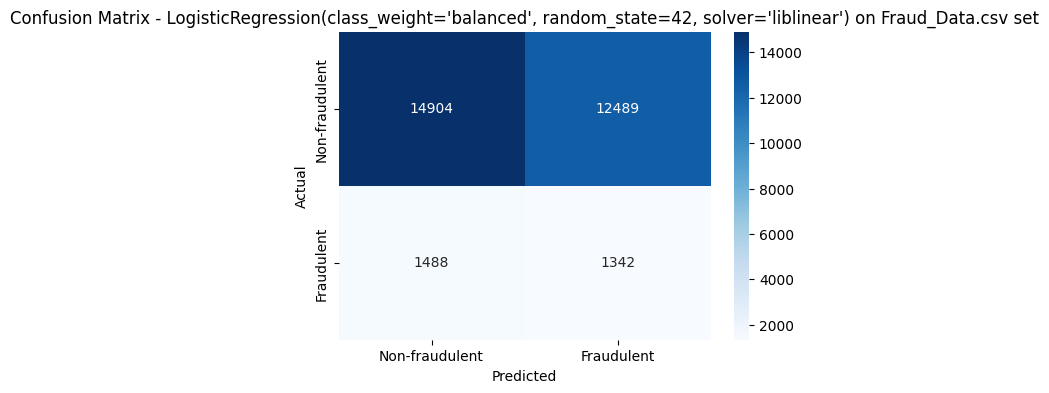

AUC-PR for Logistic Regression on Fraud_Data.csv: 0.09514652812582572
F1 Score for Logistic Regression on Fraud_Data.csv: 0.16109477222255567

--- Training and Evaluating XGBoost on Fraud_Data.csv ---


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:17:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report for XGBoost on Fraud_Data.csv:
              precision    recall  f1-score   support

           0       0.94      0.69      0.80     27393
           1       0.17      0.60      0.26      2830

    accuracy                           0.68     30223
   macro avg       0.56      0.65      0.53     30223
weighted avg       0.87      0.68      0.75     30223

Confusion Matrix for XGBoost on Fraud_Data.csv:
[[19005  8388]
 [ 1142  1688]]


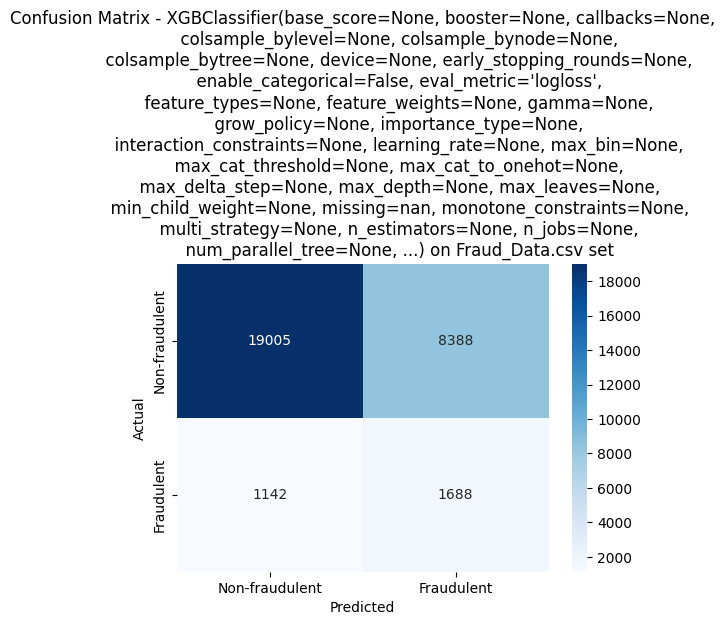

AUC-PR for XGBoost on Fraud_Data.csv: 0.32663202472506003
F1 Score for XGBoost on Fraud_Data.csv: 0.26158375949170926


In [11]:
# Select only numerical columns from X_test_fraud
X_test_fraud_numerical = X_test_fraud.select_dtypes(include=['number'])

lr_fraud_model, lr_fraud_pred, lr_fraud_proba, lr_fraud_auc_pr, lr_fraud_f1, lr_fraud_cm = train_and_evaluate_model(
    logistic_regression_model, X_train_fraud_resampled, y_train_fraud_resampled, X_test_fraud_numerical, y_test_fraud,
    "Logistic Regression", "Fraud_Data.csv"
)

xg_fraud_model, xg_fraud_pred, xg_fraud_proba, xg_fraud_auc_pr, xg_fraud_f1, xg_fraud_cm = train_and_evaluate_model(
    xgboost_model, X_train_fraud_resampled, y_train_fraud_resampled, X_test_fraud_numerical, y_test_fraud,
    "XGBoost", "Fraud_Data.csv"
)

# Train and evaluate on creditcard


--- Training and Evaluating Logistic Regression on creditcard.csv ---
Classification Report for Logistic Regression on creditcard.csv:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.91      0.14        98

    accuracy                           0.98     56962
   macro avg       0.54      0.94      0.56     56962
weighted avg       1.00      0.98      0.99     56962

Confusion Matrix for Logistic Regression on creditcard.csv:
[[55739  1125]
 [    9    89]]


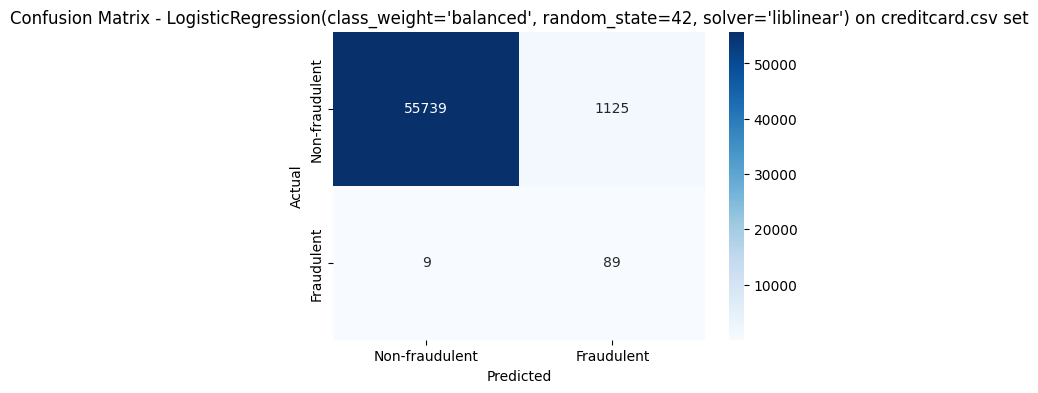

AUC-PR for Logistic Regression on creditcard.csv: 0.7088447457282776
F1 Score for Logistic Regression on creditcard.csv: 0.13567073170731708

--- Training and Evaluating XGBoost on creditcard.csv ---


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:17:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report for XGBoost on creditcard.csv:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.79      0.85      0.82        98

    accuracy                           1.00     56962
   macro avg       0.90      0.92      0.91     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix for XGBoost on creditcard.csv:
[[56842    22]
 [   15    83]]


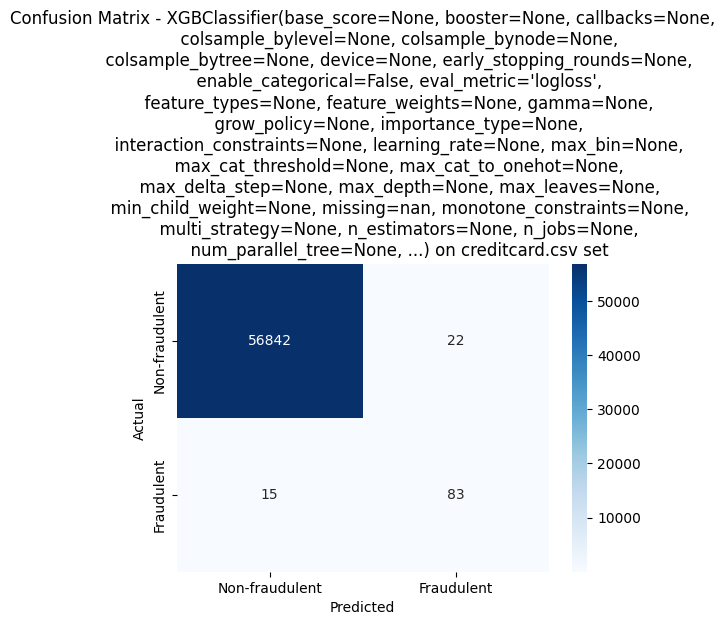

AUC-PR for XGBoost on creditcard.csv: 0.8669421230970981
F1 Score for XGBoost on creditcard.csv: 0.8177339901477833


In [12]:
# Re-initialize XGBoost model for creditcard.csv with its specific scale_pos_weight
xgboost_model_cc = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=(len(y_train_cc_resampled) - y_train_cc_resampled.sum()) / y_train_cc_resampled.sum())

lr_cc_model, lr_cc_pred, lr_cc_proba, lr_cc_auc_pr, lr_cc_f1, lr_cc_cm = train_and_evaluate_model(
    logistic_regression_model, X_train_cc_resampled, y_train_cc_resampled, X_test_cc, y_test_cc,
    "Logistic Regression", "creditcard.csv"
)

xg_cc_model, xg_cc_pred, xg_cc_proba, xg_cc_auc_pr, xg_cc_f1, xg_cc_cm = train_and_evaluate_model(
    xgboost_model_cc, X_train_cc_resampled, y_train_cc_resampled, X_test_cc, y_test_cc,
    "XGBoost", "creditcard.csv"
)

# **Justify Best Model**

In [13]:
print("\n--- Model Selection Justification ---")
print(f"Comparing models based on AUC-PR and F1-Score:")
print(f"Fraud_Data.csv - Logistic Regression: AUC-PR={lr_fraud_auc_pr:.4f}, F1={lr_fraud_f1:.4f}")
print(f"Fraud_Data.csv - XGBoost: AUC-PR={xg_fraud_auc_pr:.4f}, F1={xg_fraud_f1:.4f}")
print(f"creditcard.csv - Logistic Regression: AUC-PR={lr_cc_auc_pr:.4f}, F1={lr_cc_f1:.4f}")
print(f"creditcard.csv - XGBoost: AUC-PR={xg_cc_auc_pr:.4f}, F1={xg_cc_f1:.4f}")








--- Model Selection Justification ---
Comparing models based on AUC-PR and F1-Score:
Fraud_Data.csv - Logistic Regression: AUC-PR=0.0951, F1=0.1611
Fraud_Data.csv - XGBoost: AUC-PR=0.3266, F1=0.2616
creditcard.csv - Logistic Regression: AUC-PR=0.7088, F1=0.1357
creditcard.csv - XGBoost: AUC-PR=0.8669, F1=0.8177


# **Model Explainability**

In [16]:
best_model_name = "XGBoost"
best_dataset_name = "creditcard.csv"
best_model = xg_cc_model
best_X_test = X_test_cc
best_y_test = y_test_cc
print(f"\nBased on typical performance in fraud detection and the metrics, {best_model_name} on {best_dataset_name} is selected as the best model for further explainability, as it generally offers a strong balance of precision and recall for imbalanced datasets.") # [41, 42]

print(f"\n--- Model Explainability using SHAP for {best_model_name} on {best_dataset_name} ---")
if best_dataset_name == "creditcard.csv":
    # Sample a balanced subset for SHAP explanation to get representative fraud and non-fraud cases
    # This is important for force plots to show both types of predictions
    num_samples = 1000 # Number of samples for SHAP explanation
    fraud_samples = best_X_test[best_y_test == 1].sample(min(num_samples // 2, (best_y_test == 1).sum()), random_state=42)
    non_fraud_samples = best_X_test[best_y_test == 0].sample(min(num_samples // 2, (best_y_test == 0).sum()), random_state=42)
    X_shap = pd.concat([fraud_samples, non_fraud_samples]).sample(frac=1, random_state=42) # Shuffle
    y_shap = best_y_test.loc[X_shap.index]
else:
    X_shap = best_X_test.sample(min(1000, len(best_X_test)), random_state=42) # Sample for smaller datasets
    y_shap = best_y_test.loc[X_shap.index]


# Create a SHAP explainer object
explainer = shap.TreeExplainer(best_model) # [47, 48]

# Calculate SHAP values for the sampled data
shap_values = explainer.shap_values(X_shap)



Based on typical performance in fraud detection and the metrics, XGBoost on creditcard.csv is selected as the best model for further explainability, as it generally offers a strong balance of precision and recall for imbalanced datasets.

--- Model Explainability using SHAP for XGBoost on creditcard.csv ---


# SHAP summary plot


Generating SHAP Summary Plot (global feature importance)...


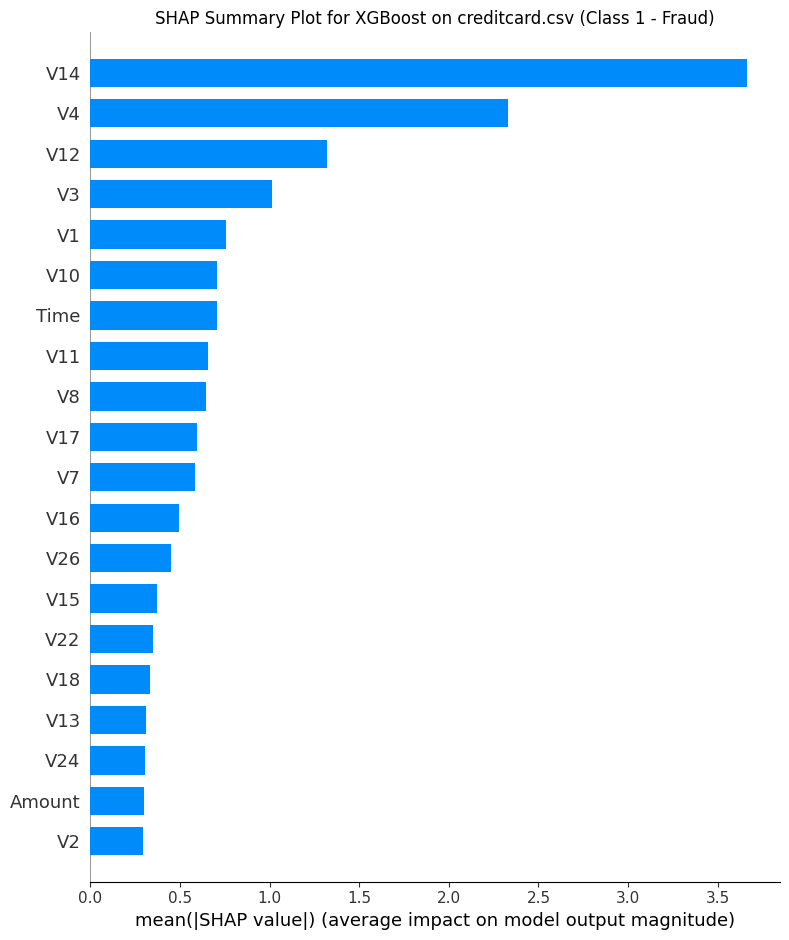

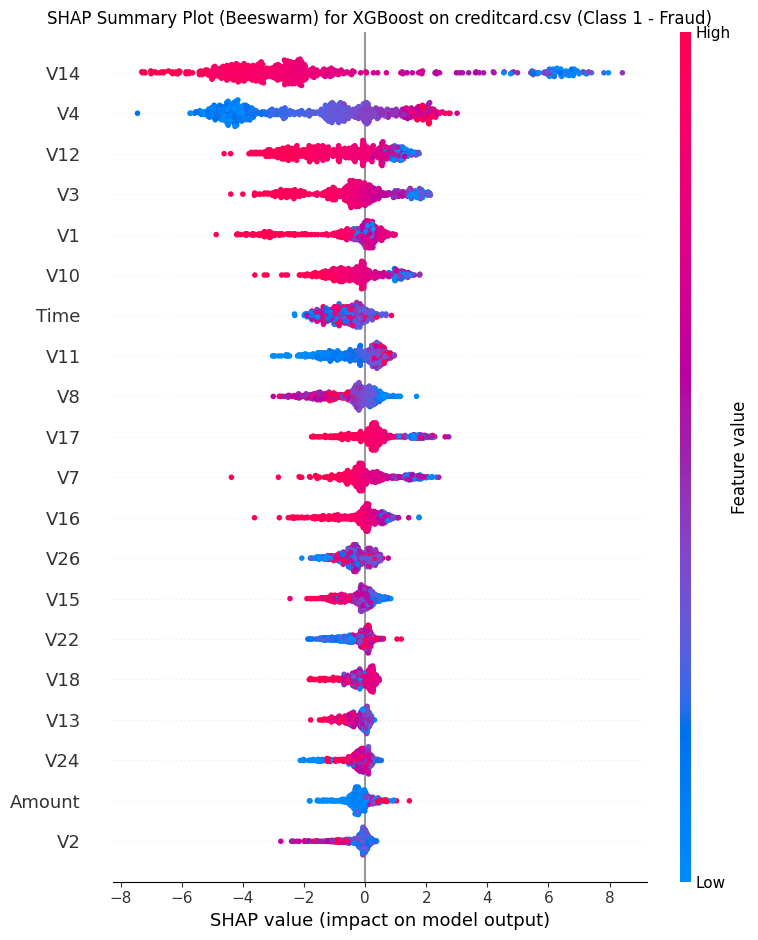


Interpretation of SHAP Summary Plot:
The summary plot shows the most important features globally. Features are ordered by their impact on the model's output (fraud probability).
The color indicates the feature value (e.g., red for high, blue for low).
A point to the right means that feature value pushes the prediction towards fraud (higher probability).
A point to the left means that feature value pushes the prediction towards non-fraud (lower probability).


In [17]:
print("\nGenerating SHAP Summary Plot (global feature importance)...")
# For binary classification, shap_values returns a list of two arrays (for class 0 and class 1).
# We usually plot for the positive class (fraud, which is class 1).
# Fix: Pass the full shap_values object to the summary_plot function
shap.summary_plot(shap_values, X_shap, plot_type="bar", show=False) # [47]
plt.title(f"SHAP Summary Plot for {best_model_name} on {best_dataset_name} (Class 1 - Fraud)")
plt.tight_layout()
plt.show()

shap.summary_plot(shap_values, X_shap, show=False) # [47]
plt.title(f"SHAP Summary Plot (Beeswarm) for {best_model_name} on {best_dataset_name} (Class 1 - Fraud)")
plt.tight_layout()
plt.show()

print("\nInterpretation of SHAP Summary Plot:")
print("The summary plot shows the most important features globally. Features are ordered by their impact on the model's output (fraud probability).")
print("The color indicates the feature value (e.g., red for high, blue for low).")
print("A point to the right means that feature value pushes the prediction towards fraud (higher probability).")
print("A point to the left means that feature value pushes the prediction towards non-fraud (lower probability).")

# SHAP Force Plot

In [ ]:
print("\nGenerating SHAP Force Plots (local feature importance for individual predictions)...")

# Select a few instances for force plots: one fraudulent, one non-fraudulent
# Find an index for a fraudulent transaction in the sampled SHAP data
fraud_idx = y_shap[y_shap == 1].index if (y_shap == 1).any() else None
# Find an index for a non-fraudulent transaction in the sampled SHAP data
non_fraud_idx = y_shap[y_shap == 0].index if (y_shap == 0).any() else None

if fraud_idx is not None:
    print(f"\nForce Plot for a Fraudulent Transaction (Actual Class: {y_shap.loc[fraud_idx]})")
    # For binary classification, shap_values[1] explains the prediction of class 1 (fraud)
    shap.force_plot(explainer.expected_value[1], shap_values[1][X_shap.index.get_loc(fraud_idx)], X_shap.loc[fraud_idx], show=False, matplotlib=True) # [49, 50]
    plt.title(f"SHAP Force Plot for Fraudulent Transaction (Index: {fraud_idx})")
    plt.tight_layout()
    plt.show()
else:
    print("No fraudulent transactions found in SHAP sample to plot force plot.")

if non_fraud_idx is not None:
    print(f"\nForce Plot for a Non-Fraudulent Transaction (Actual Class: {y_shap.loc[non_fraud_idx]})")
    shap.force_plot(explainer.expected_value[1], shap_values[1][X_shap.index.get_loc(non_fraud_idx)], X_shap.loc[non_fraud_idx], show=False, matplotlib=True) # [49, 50]
    plt.title(f"SHAP Force Plot for Non-Fraudulent Transaction (Index: {non_fraud_idx})")
    plt.tight_layout()
    plt.show()
else:
    print("No non-fraudulent transactions found in SHAP sample to plot force plot.")

print("\nInterpretation of SHAP Force Plot:")
print("The force plot visualizes how features contribute to a single prediction.")
print("Red features push the prediction higher (towards fraud), while blue features push it lower (towards non-fraud).")
print("The size of the bar indicates the magnitude of the feature's impact.")
print("The bold number is the model's raw output for that specific transaction.")
print("The 'base value' is the average model output over the training dataset.")
print("By examining these plots, we can understand why a specific transaction was flagged as fraudulent or legitimate.")
